In [2]:
import torch, sys
import numpy as np
from Packages.RegistrationFunc import *
from Packages.SplitEbinMetric import *
from Packages.GeoPlot import *
import scipy.io as sio
import matplotlib.pyplot as plt


i0 = sio.loadmat('Data/sigma20-20.mat')
i1 = sio.loadmat('Data/sigma10-20.mat')
i0 = torch.from_numpy(i0['image']).double()
i1 = torch.from_numpy(i1['image']).double()

print(torch.min(i0),torch.min(i1))
print(torch.max(i0),torch.max(i1))

tensor(0.0019, dtype=torch.float64) tensor(1.6374e-07, dtype=torch.float64)
tensor(1., dtype=torch.float64) tensor(1., dtype=torch.float64)


In [3]:
# define the pullback action of phi
def phi_pullback(phi, g):
    idty = get_idty(*g.shape[-2:])
#     four layers of scalar field, of all 1, all 0, all 1, all 0, where the shape of each layer is g.shape[-2:]?
    d_phi = get_jacobian_matrix(phi - idty) + torch.einsum("ij,mn->ijmn", [torch.eye(2,dtype=torch.double),
                                                                           torch.ones(g.shape[-2:],dtype=torch.double)])
    g_phi = compose_function(g, phi)
#     matrix multiplication
# the last two dimension stays the same means point-wise multiplication, ijmn instead of jimn means the first d_phi need to be transposed
    return torch.einsum("ijmn,ikmn,klmn->jlmn",[d_phi, g_phi, d_phi])


# define the energy functional
def Energy(phi, g0, g1, f0, f1, sigma, lambd, mask): 

    '''
    compute the energy functional
    
    Parameters
    -----
    phi: the diffeomorphism
        size: 2 x N x N
        
    g0, g1: the initial and the target metrics
        size: 2 x 2 x N x N
        
    f0, f1: weighting tensors
        size: 2 x 2 x N x N
    
    sigma: the constant regularization parameter
    
    lambd: the weight that measures the change in the volumn density
    
    Returns
    -----
    The energy fuctional 
    
    ''' 
    phi_star_g1 = phi_pullback(phi, g1)
    phi_star_f1 = phi_pullback(phi, f1)
#     means d(g_0,\phi^*g_1)=d(\phi_*g_0,g_1), d(f_0,\phi^*f_1)=d(\phi_*f_0,f_1)?
    E1 = sigma*Squared_distance_Ebin(f0, phi_star_f1, lambd, mask)
    E2 = Squared_distance_Ebin(g0, phi_star_g1, lambd, mask)
    
    return E1 + E2


# define the energy functional
def Energy_L2(phi, i0, i1, sigma_i): # 

    '''
    compute the energy functional
    
    Parameters
    -----
    phi: the diffeomorphism
        size: 2 x N x N
        
    g0, g1: the initial and the target metrics
        size: 2 x 2 x N x N
        
    f0, f1: weighting tensors
        size: 2 x 2 x N x N
    
    sigma: the constant regularization parameter
    
    lambd: the weight that measures the change in the volumn density
    
    Returns
    -----
    The energy fuctional 
    
    ''' 
    phi_star_i1 = compose_function(i1, phi)
    E_i = sigma_i*torch.sum((i0 - phi_star_i1)**2)
    
    return E_i

In [4]:
height = i0.size(-2)
width = i0.size(-1)

In [5]:
# define the Laplacian inverse

def laplace_inverse(u):
    '''
    this function computes the laplacian inverse of a vector field u of size 2 x size_h x size_w 
    '''
    size_h, size_w = u.shape[-2:]
    shape = u.shape
    idty = get_idty(size_h, size_w).numpy()
    lap = 4. - 2.*(np.cos(2.*np.pi*idty[0]/size_w) + np.cos(2.*np.pi*idty[1]/size_h))
    lap[0,0] = 1.
    lapinv = 1./lap
    lap[0,0] = 0.
    lapinv[0,0] = 1.
    
    u = u.detach().numpy()
    fx = np.fft.fftn(u[0])
    fy = np.fft.fftn(u[1])
    fx *= lapinv
    fy *= lapinv
    vx = torch.from_numpy(np.real(np.fft.ifftn(fx)))
    vy = torch.from_numpy(np.real(np.fft.ifftn(fy)))
    
    return torch.stack((vx,vy))

In [6]:
def checkNaN(A):
    if (A != A).any():
        print('NaN')

## Pytorch

In [7]:
%%time

%matplotlib inline

lambd = 0.5

# sigma_i = 0.5*1e3
sigma_i = 1
epsilon = 1e-2
# epsilon = 1e3
# epsilon = 1e-2
Num_ite = 3000#10000
count = 0

phi_inv = get_idty(height, width)
phi = get_idty(height, width)

idty = get_idty(height, width)
idty.requires_grad_()
E_all = []
epsilon_all = []

CPU times: user 13 ms, sys: 4.65 ms, total: 17.6 ms
Wall time: 115 ms


/home/sci/hdai/anaconda2/envs/fno/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


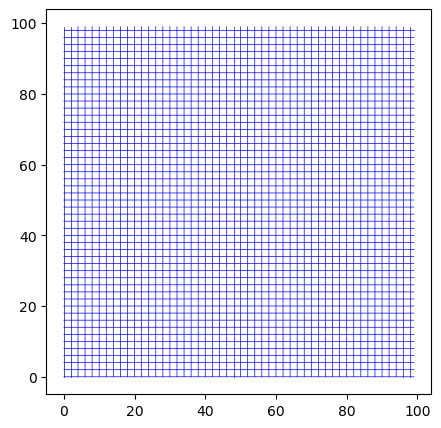

294.78658505118415


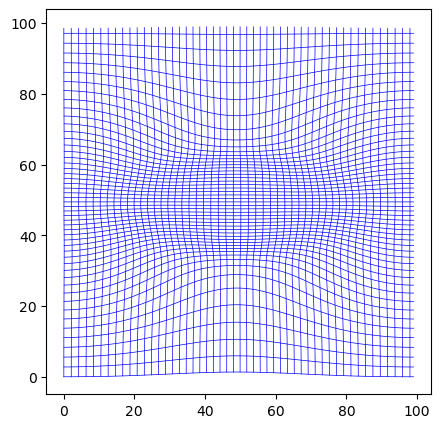

19.6574674724043


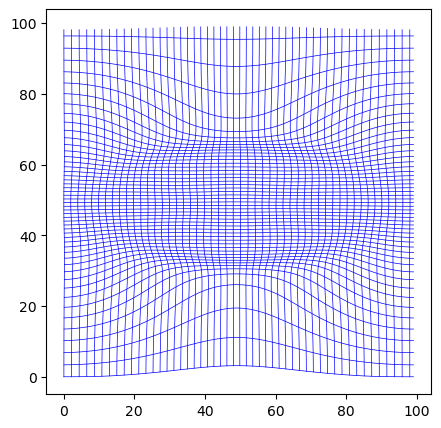

8.254325841456103


In [8]:
E = torch.tensor([np.inf], dtype=torch.double) 

for i in range(Num_ite):
    phi_actsi0 = compose_function(i0, phi_inv)
    
    E0 = E.clone()
    E = Energy_L2(idty, phi_actsi0, i1, sigma_i)
    E.backward()
    
    if (E-E0)/E0>1e-7:
        count +=1
        print(count)
        epsilon = epsilon/1.2
    
    v = - laplace_inverse(idty.grad)
    E_all.append(E.item())
    alpha = epsilon/torch.norm(idty.grad)
#     alpha = epsilon
    
    with torch.no_grad():
#         psi =  idty + epsilon*v  
        psi =  idty + alpha*v  
        psi[0][psi[0]>width-1]=width-1
        psi[1][psi[1]>height-1]=height-1
        psi[psi<0]=0
        
#         psi_inv =  idty - epsilon*v
        psi_inv =  idty - alpha*v
        psi_inv[0][psi_inv[0]>width-1]=width-1
        psi_inv[1][psi_inv[1]>height-1]=height-1
        psi_inv[psi_inv<0]=0
        
        phi = compose_function(psi, phi)
        phi_inv = compose_function(phi_inv, psi_inv)
        
        if i%1000==0:
            plot_diffeo(phi, step_size=2, show_axis=True)
            print(E.item())
        
        idty.grad.data.zero_()
    
    if abs((E-E0)/E0)<1e-4 or count>200:#:
        break
        
print(E.grad_fn)

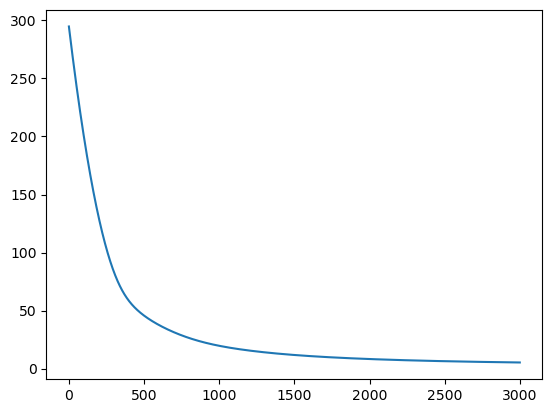

In [9]:
plt.plot(E_all)

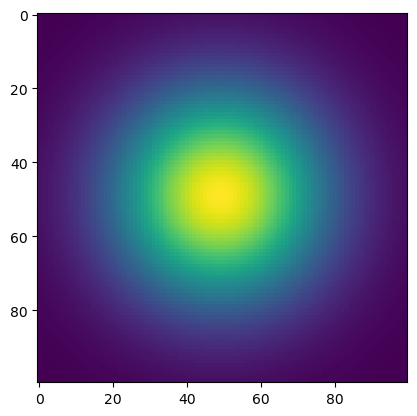

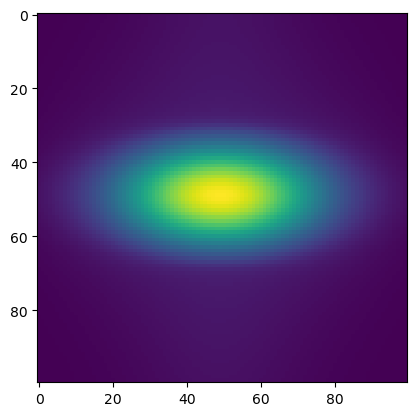

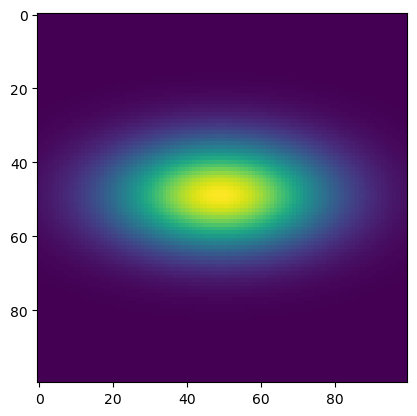

In [10]:
i11_n = compose_function(i0, phi_inv)
plt.imshow(i0)
plt.show()
plt.imshow(i11_n)
plt.show()
plt.imshow(i1)
plt.show()

In [10]:
sio.savemat('gaussian_phi_inv.mat', {'diffeo': phi_inv.detach().numpy()})
sio.savemat('gaussian_phi.mat', {'diffeo': phi.detach().numpy()})

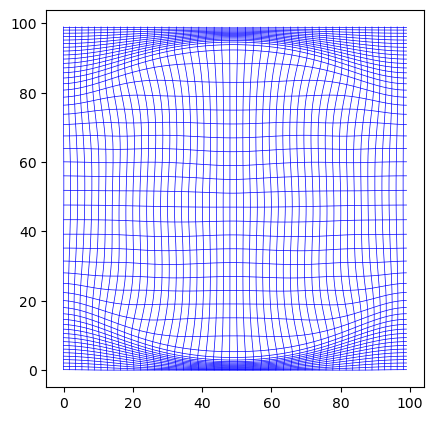

In [11]:
plot_diffeo(phi_inv, step_size=2, show_axis=True)

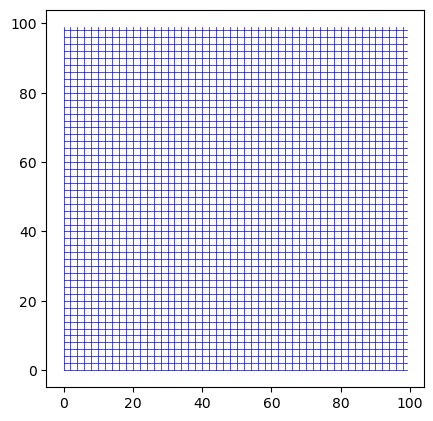

In [12]:
plot_diffeo(idty, step_size=2, show_axis=True)

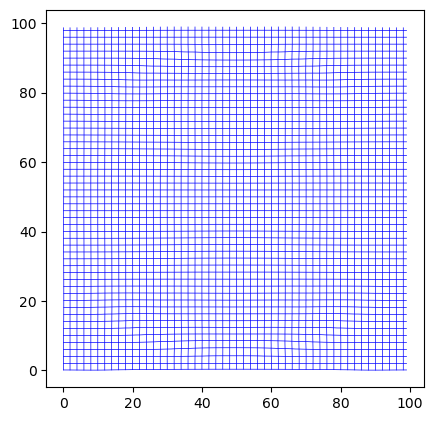

In [14]:
# phi = torch.from_numpy(sio.loadmat('InvCubic1246TemplateEbin/Cubic1_noweight_phi_ebin.mat')['diffeo']).double()
# phi_inv = torch.from_numpy(sio.loadmat('InvCubic1246TemplateEbin/Cubic1_noweight_phi_inv_ebin.mat')['diffeo']).double()
idty = compose_function(phi_inv, phi)
plot_diffeo(idty, step_size=2, show_axis=True)